In [266]:
import osmnx as ox
import numpy as np
import pandas as pd
import folium

## Downloading the data as a graph and visualizing

In [59]:
gdf = ox.geocode_to_gdf('rochester, ny')

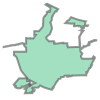

In [60]:
gdf.geometry[0]

In [314]:
bike_network = ox.graph_from_polygon(gdf.geometry[0], network_type='bike')


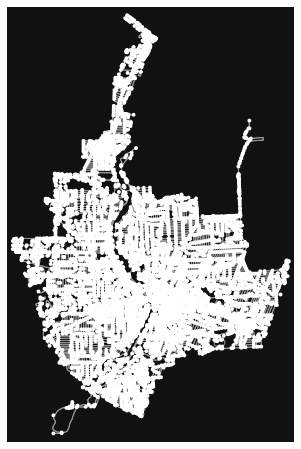

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [121]:
ox.plot.plot_graph(bike_network)

## Visualizing specific streets or segments of streets

To query by attributes like street name, we can download the network as a geodataframe.

In [76]:
tab_form = ox.geometries.geometries_from_polygon(gdf.geometry[0],tags={'highway':True})

### `street` like Broad St

The [TIGER](https://wiki.openstreetmap.org/wiki/TIGER) attributes seem to be the most useful for this type of query.

In [127]:
broad_street = tab_form[tab_form['tiger:name_base']=='Broad']

In [231]:
m = folium.Map(location=[43.15, -77.6750], tiles="Stamen Toner", zoom_start=13)

folium.GeoJson(broad_street[['name','geometry']].to_json(), name='Broad Street'
).add_to(m)

In [232]:
m

## Intersection of Broad and Allen

In [235]:
allen_street = tab_form[tab_form['tiger:name_base']=='Allen']

In [236]:
first_intersection = broad_street.sjoin(allen_street[['geometry','name']], how='inner', rsuffix='r').iloc[0]

In [285]:
first_intersection

highway                                               primary
geometry    LINESTRING (-77.6252208 43.1581155, -77.625149...
ref                                                     NY 31
railway                                                   NaN
old_ref                                                   NaN
                                  ...                        
ways                                                      NaN
type                                                      NaN
index_r0                                                  way
index_r1                                             68312333
name_r                                           Allen Street
Name: (way, 597508984), Length: 189, dtype: object

In [237]:
intersection_point = (
    first_intersection.geometry.intersection(
        allen_street.loc[(first_intersection['index_r0'], first_intersection['index_r1']),:].geometry))

In [233]:
folium.Marker(location=(intersection_point.coords[0][1],intersection_point.coords[0][0]) , name='Allen St. Intersection'
).add_to(m)

In [234]:
m

### Broad St, between Smith and Allen

Many of the reccommended enhancements are posed in this way, for example in the Bikeable Cities report, they provide a list of priorities:

> 
> - Broad St between Smith and Allen – 32 feet wide, on-street parking present
> - Genesee St south of Melrose – 43 feet wide, on-street parking present
> - Portland Ave between North and Central Park – 43 feet wide, on-street parking present
> - Monroe Ave between Howell and Alexander – 43 feet wide, on-street parking present
> - Monroe Avenue east of Goodman Street – 46 feet wide, on- street parking present

After some digging, I think this is best done by iterating through the graph, rather than the GDF.

In [330]:
broadway_edges = {}
allen_intersection = []
smith_intersection = []
for u,v in bike_network.edges():
    d = bike_network.get_edge_data(u,v,0)
    if 'broad' in d.get('name', '').lower():
        broadway_edges[(u,v)] = d

In [346]:
nodes = []
for u, v in broadway_edges.keys():
    nodes += [u,v]
nodes = set(nodes)


In [361]:
smith_edges = {}
allen_edges = {}
for u,v in bike_network.edges(nodes):
    d = bike_network.get_edge_data(u,v,0)
    street_name = d.get('name','')
    if isinstance(street_name, list): # Some street names are lists
        street_name=' '.join(street_name)
    
    street_name = street_name.lower()
    
    # Change these to regexes
    if 'smith ' in street_name:
        smith_edges[(u,v)] = d
    elif 'allen ' in street_name:
        allen_edges[(u,v)] = d
    else:
        pass

In [362]:
smith_edges

{(212732088, 212732103): {'osmid': 610921342,
  'name': 'Smith Street',
  'highway': 'tertiary',
  'oneway': False,
  'length': 32.251,
  'geometry': <shapely.geometry.linestring.LineString at 0x409500a820>},
 (212732088, 1242662146): {'osmid': 672572099,
  'name': 'Smith Street',
  'highway': 'tertiary',
  'oneway': False,
  'length': 119.67599999999999,
  'geometry': <shapely.geometry.linestring.LineString at 0x409500a580>},
 (212858130, 212604432): {'osmid': [183385272, 20131265],
  'name': ['Goldsmith Place', 'Spring Street'],
  'highway': 'residential',
  'oneway': False,
  'length': 207.715,
  'geometry': <shapely.geometry.linestring.LineString at 0x40fa15dca0>}}

In [363]:
allen_edges

{(212662512, 212741199): {'osmid': [593481589, 68312333],
  'oneway': True,
  'name': ['Platt Street', 'Allen Street'],
  'highway': 'secondary',
  'length': 223.772,
  'geometry': <shapely.geometry.linestring.LineString at 0x40f6fca1f0>}}

In [376]:
# TODO -- postprocess these edges to make sure we only grab ones from the subgraph.
# TODO -- fix regexes

In [375]:
ox.folium.plot_route_folium(bike_network.subgraph(nodes), ox.distance.shortest_path(bike_network.subgraph(nodes), 212662512,212732088))

# TODO
- Checkout simplification module
